In [1]:
import torch
import torch.nn as nn #defining neural network
import torch.nn.functional as F #helper
from torch.utils.data import DataLoader #batching
from torchvision import datasets, transforms #loading datasets
from torchvision.utils import make_grid  #for visualization

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(96)

# Load dataset

## Dataset

In [3]:
# norm tranform (0,255 -> 0,1)
transform = transforms.ToTensor()

# load data
train_data = datasets.MNIST(root="datasets",train=True,download=True,transform=transform)

# validation set
train_set,val_set = torch.utils.data.random_split(train_data,[50000,10000])

#test
test_set  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

## Dataloader

In [5]:
# for batch

train_loader = DataLoader(train_set,batch_size = 64,shuffle=True)
val_loader = DataLoader(val_set,batch_size = 64,shuffle=True)
test_loader = DataLoader(test_set,batch_size = 10000,shuffle=False) # no need to shuffle and batch cuda will not out of memory because no grad cal



In [6]:
len(train_loader) # sample 782*64 = 50048 (50000 sample)

782

torch.Size([64, 1, 28, 28])
torch.Size([64])
label:  2


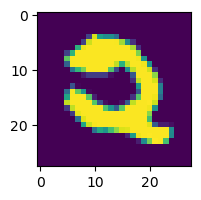

In [7]:

for images,labels in train_loader:
    break

print(images.shape)
print(labels.shape)

plt.figure(figsize=(2,2))
plt.imshow(np.transpose(images[0],(1,2,0)))
print("label: ",labels[0].item())

# network

In [8]:
images.shape

torch.Size([64, 1, 28, 28])

$$O = \frac{I-F+2P}{S} + 1$$

In [9]:
# conv1d = time series, language, signal
# conv2d = images, spectrum
# conv3d = video
# [1,3,]
# nn.ModuleList()

layer1 = nn.Conv2d(in_channels=images.shape[1],out_channels=3,kernel_size=(5,3),stride=1,padding=(2,1))
output = layer1(images)
output.shape



torch.Size([64, 3, 28, 28])

In [10]:
output = layer1(images)
output.shape

torch.Size([64, 3, 28, 28])

In [11]:
output.flatten().shape

torch.Size([150528])

In [12]:
a = [1,2,3]
a[1:]

[2, 3]

In [13]:
# version 0
class POOH_CNN(nn.Module):

    def __init__(self,input_shape,output_shape,conv_lc = [],linear_lc =[]):
        super().__init__()
        """
        everything square because it easy

        input_shape: int 
        output_shape: int
        linear_lc : [node1,node2,...]
        conv_lc : [input,filter, ..]   input => (chanel)    filter => (chanel,kernal size) 
        """

        self.conv_list = nn.ModuleList([
                                        nn.Conv2d(conv_lc[i][0],conv_lc[i+1][0],kernel_size=conv_lc[i+1][1] ,stride=1,padding=1) 
                                        for i in range(len(conv_lc[:-1])) 
                                        ])
        
        curr_shape = input_shape
        for c in conv_lc[1:]:
            curr_shape = self.cal_convshape(I = curr_shape,F=c[1])

        self.conv_out = int(conv_lc[-1][0]*curr_shape**2)

        linear_lc = [self.conv_out]+linear_lc+[output_shape]

        self.linear_list = nn.ModuleList([
                                        nn.Linear(linear_lc[i],linear_lc[i+1])
                                          for i in range(len(linear_lc[:-1]))
                                          ])

    def cal_convshape(self,I,F,P=1,S=1):
        return ((I-F+2*P)/S)+1
    
    def cal_pad(self,F,S):
        pass

    def forward(self,images):
        
        output = images
        for layer in self.conv_list:
            output = F.relu(layer(output))

        output = output.reshape(-1,self.conv_out)
        for layer in self.linear_list[:-1]:
            output = F.relu(layer(output))

        output = self.linear_list[-1](output) 
        

        return output







In [14]:
images.shape

torch.Size([64, 1, 28, 28])

In [15]:
#test first

model = POOH_CNN(input_shape = images.shape[-1],output_shape=10,conv_lc=[(images.shape[1],None),(5,3),(10,3)],linear_lc=[120,84])


In [16]:
model.conv_list

ModuleList(
  (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [17]:
model.linear_list

ModuleList(
  (0): Linear(in_features=7840, out_features=120, bias=True)
  (1): Linear(in_features=120, out_features=84, bias=True)
  (2): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
output  = model(images)
output.shape

torch.Size([64, 10])

In [19]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [20]:
count_parameters(model)

    45
     5
   450
    10
940800
   120
 10080
    84
   840
    10
______
952444


# training

In [21]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
num_epochs = 1
for i in range(num_epochs):
    for images, labels in train_loader:
        y_hat = model(images)
        loss  = criterion(y_hat, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [23]:
loss.item()

0.028779927641153336

# Testing

In [24]:
model.eval() #this will turn off dropout, batch norm
with torch.no_grad():  #this will turn off gradient calculations
    for images, labels in test_loader:
        y_hat = model(images)
        loss = criterion(y_hat, labels)
        
print("Cross Entrophy Loss: ", loss.item())

Cross Entrophy Loss:  0.08101659268140793


# analysis

In [25]:
y_hat_pred = torch.max(y_hat, 1)[1]
y_hat_pred.shape

torch.Size([10000])

In [26]:

#confusion matrix
confusion_matrix(y_hat_pred, labels)

array([[ 974,    0,    3,    2,    1,    4,    7,    0,    3,    4],
       [   1, 1127,    1,    0,    1,    0,    4,    5,    1,    6],
       [   0,    2, 1021,   14,    1,    0,    0,   15,    7,    1],
       [   0,    1,    2,  973,    0,    6,    1,    0,    3,    1],
       [   0,    1,    1,    0,  970,    0,    6,    1,    2,   18],
       [   1,    0,    0,    6,    0,  858,    5,    0,    0,    4],
       [   3,    2,    0,    0,    5,    4,  921,    0,    2,    0],
       [   1,    1,    3,    7,    0,    2,    0, 1004,    2,   14],
       [   0,    1,    1,    5,    3,   15,   14,    1,  951,   11],
       [   0,    0,    0,    3,    1,    3,    0,    2,    3,  950]],
      dtype=int64)

# Inference

In [27]:

test_set[0][0].shape
test_set[0][1]

7

In [28]:

pred = model(test_set[0][0])
pred

tensor([[ -9.2589,  -2.3991,   1.3148,  -0.0519, -10.6724,  -5.8069, -17.0051,
          12.4333,  -5.4502,  -1.7179]], grad_fn=<AddmmBackward0>)

In [33]:
pred.argmax()

tensor(7)